# 1.4 RflySim 无人机视觉感知

Rflysim的无人机视觉和airsim基本也是类似的，都是基于虚幻引擎开发的，在无人机开发中，其摄像头数据采集功能至关重要。

<img src="img/rflysim_sensor.png" width='600px' />

### 支持多种摄像头类型

Rflysim 支持多种常见摄像头类型，如场景摄像头（用于获取无人机视角下的彩色图像）、深度摄像头（可生成场景的深度信息，帮助无人机感知距离）以及鱼眼摄像头（提供更广阔的视野范围，适用于全景数据采集）。开发者能依据具体的开发需求，轻松在代码中选择并配置所需的摄像头类型。

### 灵活的数据采集配置

开发者可对摄像头参数进行精细设置，像图像分辨率（例如从低分辨率的 320x240 到高分辨率的 4K 甚至更高）、帧率（可根据任务需求调整，如对于实时性要求高的跟踪任务，可设置较高帧率）、视野角度等。同时，还能指定数据采集的频率，是按固定时间间隔采集，还是在特定事件触发时采集，这为不同的应用场景提供了极大的灵活性。

### 便捷的数据获取方式

在代码层面，通过 Rflysim 提供的 API，开发者能以简单的函数调用获取摄像头数据。通过相应指令获取摄像头图像数据。这些数据以常见的图像格式（如 PNG、JPEG 用于彩色图像，或特殊格式用于深度图像数据）返回，方便后续使用 OpenCV 等图像处理库进行分析和处理。

### 相机设置

RflySim 仿真平台的传感器可进行相机、深度相机、红外、激光雷达等传感器的设置。

“TypeID”代表传感器类型 ID，其中 1:RGB 图，2:深度图，3:灰度图 4：分割图，5：测距图，20-22：激光雷达，40：红外灰度，41：热力图。

RflySim3D取图接口—取图接口VisionCaptureApi.py

In [7]:
!pip install opencv-python matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 2.6 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/8.1 MB 4.4 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 30.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 30.3 MB/s eta 0:00:00


In [17]:
import time
import math
import sys
import VisionCaptureApi
import PX4MavCtrlV4 as PX4MavCtrl
import cv2
import UE4CtrlAPI
import matplotlib.pyplot as plt

In [2]:
#Create a new MAVLink communication instance, UDP sending port (CopterSim’s receving port) is 20100
mav = PX4MavCtrl.PX4MavCtrler(1)

In [3]:
#Turn on MAVLink to monitor CopterSim data and update it in real time. 
mav.InitMavLoop()

#Turn on Offboard mode
mav.initOffboard()

#Send arm command to arm the drone,解锁
mav.SendMavArm(True) 
print("Send Arm Command")

time.sleep(2)

mav.SendPosNED(0, 0, -10, 0) 
print("起飞-------------------------")

Send Arm Command
起飞-------------------------


In [4]:
ue = UE4CtrlAPI.UE4CtrlAPI()
vis = VisionCaptureApi.VisionCaptureApi()

In [19]:
# Send command to UE4 Window 1 to change resolution 
ue.sendUE4Cmd('r.setres 1280x720w',0) # 设置UE4窗口分辨率，注意本窗口仅限于显示，取图分辨率在json中配置，本窗口设置越小，资源需求越少。
ue.sendUE4Cmd('t.MaxFPS 30',0) # 设置UE4最大刷新频率，同时也是取图频率
time.sleep(2)    

# VisionCaptureApi 中的配置函数,绝对路径，注意换成自己的
vis.jsonLoad(jsonPath=r'C:\Users\wangl\PycharmProjects\airsim_agent\rflysim\1-rflysim_basic\Config.json') # 加载Config.json中的传感器配置文件

Json use absolute path mode
jsonPath= C:\Users\wangl\PycharmProjects\airsim_agent\rflysim\1-rflysim_basic\Config.json
Got 4 vision sensors from json
Got CopterSim time Data for img


True

In [20]:
# 打印确认序号和端口自动配置正确
print(vis.VisSensor[0].SeqID)
print(vis.VisSensor[0].SendProtocol)
print(vis.VisSensor[1].SeqID)
print(vis.VisSensor[1].SendProtocol)

0
[0, 0, 0, 0, 0, 9999, 0, 0]
1
[0, 0, 0, 0, 0, 10000, 0, 0]


In [21]:
isSuss = vis.sendReqToUE4() # 向RflySim3D发送取图请求，并验证
if not isSuss: # 如果请求取图失败，则退出
    sys.exit(0)
vis.startImgCap() # 开启取图

Got start time for SeqID # 0
Got start time for SeqID # 1
Got start time for SeqID # 0
Got start time for SeqID # 1


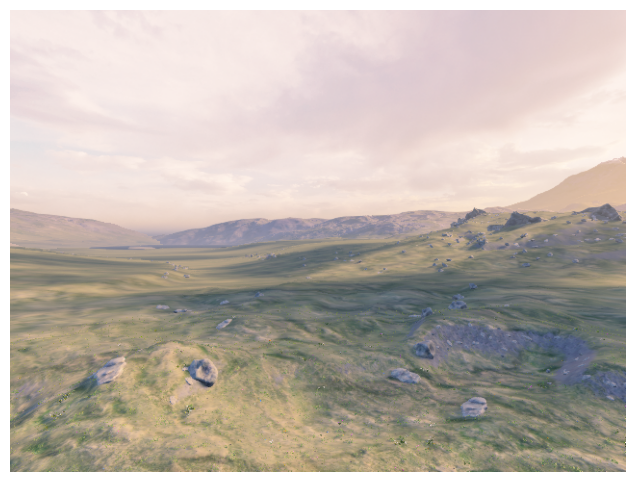

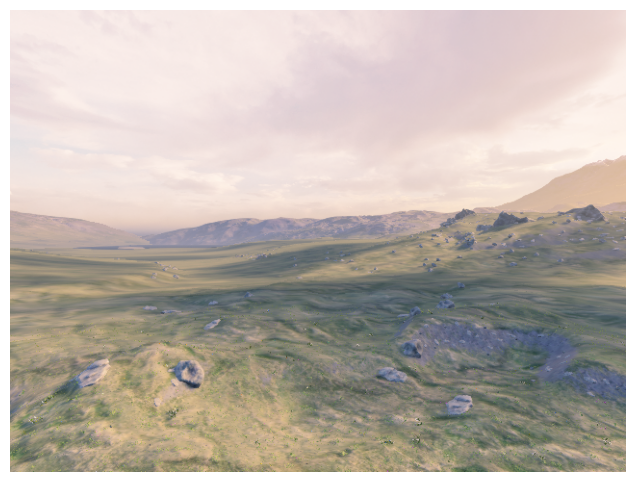

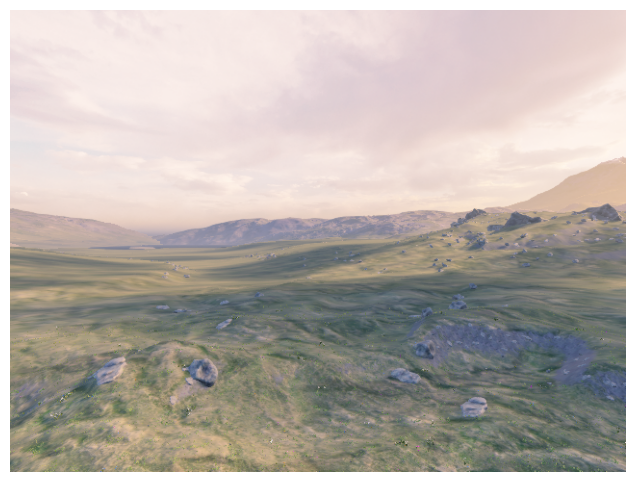

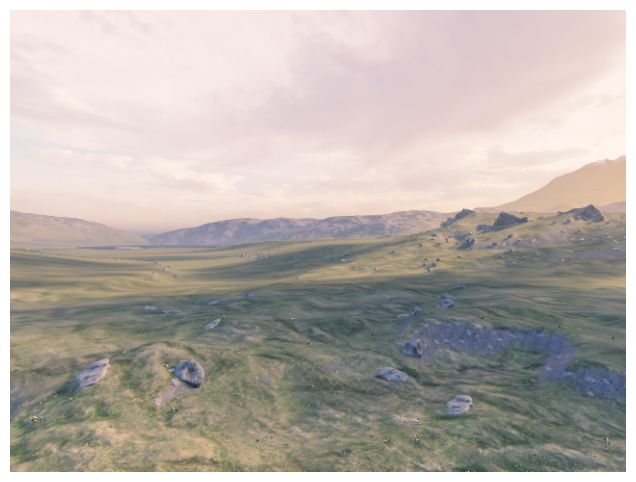

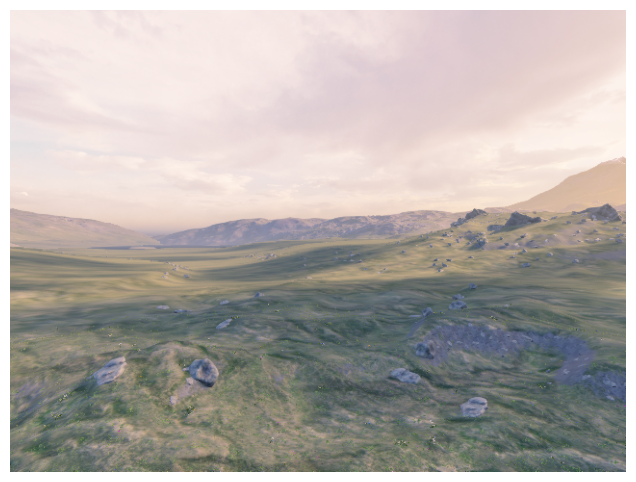

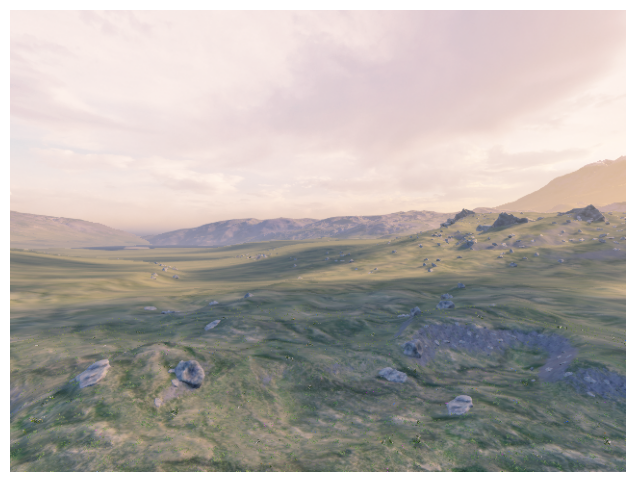

In [22]:

for i in range(3):
    for i in range(len(vis.hasData)):
        if vis.hasData[i]:
            # Process your image here
            img_bgr = vis.Img[i]
            
            # 将BGR格式转换为RGB格式，因为matplotlib默认显示RGB图像
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            
            # 在Jupyter Notebook中展示图片
            plt.figure(figsize=(10, 6))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
        
    time.sleep(1)

## 参考文档

https://rflysim.com/doc/zh/RflySimAPIs/8.RflySimVision/Intro.pdf